# Developing Brain-Computer Interfaces

Do as many repsentation for the data

Reference: https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

Licensed under the GPLv3, see LICENSE for more details.

## Learning objectives:

At a very general level:

- Adquiring the flexibility to work with domain-specific tools.
- Knowing how a sample of real user data looks like.
- Considering the sources of noise and variability in measurements.
- Being familiar with general and specific preprocessing steps.
- Overviewing machine learning methods for data analysis.
- Drafting an interactive method from an interaction modality.

Note: Learning how to use MNE is NOT a learning objective!
(but see first objective)

## Working with EEG data

Remember the intuition about how EEG data looks like!

- Continuous data that changes over time...
- ... recorded from few fixed points in space (electrodes)

WARNING:
Neurophysiological recordings very often result in:

- HUGE file sizes in disk.
- Also meaning, huge file sizes in RAM to work with them.

**One way to mitigate this is to force most operations to be in place**, so there're very few copies of similar variables around.
MNE, the package that we'll use to work the EEG data, follows this strategy.
**If you don't know what this means, please see the end of the notebook.**
*In short, always consider that is easy to accidentaly modify the values of your variables!*

### About the dataset

We will use the SPM Faces dataset.
This dataset contains evoked responses to visual stimuli.
Participants were shown a mix of images of:

- "normal"-looking faces 
- "scrambled" faces.

In theory, we will be able to *detect whether the study participant saw a normal face or not based exclusively on brain signals*.

The dataset has also been integrated into MNE, which will make our life easier for downloading.

This notebook is a modified version of:
https://mne.tools/stable/auto_examples/datasets/spm_faces_dataset_sgskip.html#ex-spm-faces

## Loading the data

IMPORTANT:
**Run the imports and data loading cell below before the class to have everything ready!**

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import mne
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

plt.close("all")
sns.set_theme()
sns.set_context("paper")

sep = lambda: print("-" * 30)

data_dir = "data"

print(__doc__)

data_path = spm_face.data_path()
subjects_dir = os.path.join(data_path, "subjects")
# raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces%d_3D.ds'
raw_fname = os.path.join(
    data_path, "MEG", "spm", "SPM_CTF_MEG_example_faces%d_3D.ds"
)

Automatically created module for IPython interactive environment


## Exploring the Raw data

In [2]:
raw = io.read_raw_ctf(raw_fname % 1, preload=True)  # Take first run

ds directory : /home/c/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01    0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01    0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /home/c/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds/SPM_CTF_MEG_example_faces1_3D.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 324474 = 324474 samples from 340 chs
Current co

The `info` method accesses the metadata is one of the most used.
https://mne.tools/stable/generated/mne.Info.html

```
- bads: channels that are too noisy or have near-zero activity.
- ch_names: names of the channels.
- chs: types of channels.
- highpass: cutoff below this frequency ("high frequencies pass").
- lowpass: cutoff above this frequency ("low frequencies pass").
- meas_date: measurement date.
- nchan: number of channels.
- projs: projections from one space to another, used e.g. to eliminate noise.
- sfreq: sample rate of the data.
```

Pay attention to "bad" channels!

In [3]:
print(raw.info)

<Info | 15 non-empty values
 bads: []
 ch_names: UPPT002, UPPT001, SCLK01-177, BG1-2908, BG2-2908, BG3-2908, ...
 chs: 2 STIM, 35 MISC, 29 REF_MEG, 274 MAG
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 lowpass: 240.0 Hz
 meas_date: 2008-11-24 09:54:00 UTC
 meas_id: 4 items (dict)
 nchan: 340
 projs: []
 sfreq: 480.0 Hz
 subject_info: 1 item (dict)
>


In [4]:
raw

<RawCTF | SPM_CTF_MEG_example_faces1_3D.meg4, 340 x 324474 (676.0 s), ~842.2 MB, data loaded>

We often want the same plots at early stages for certain neurophysiological data types.
MNE has some convenience methods for this (which you don't need to memorize)

Let's see a sample of the data!

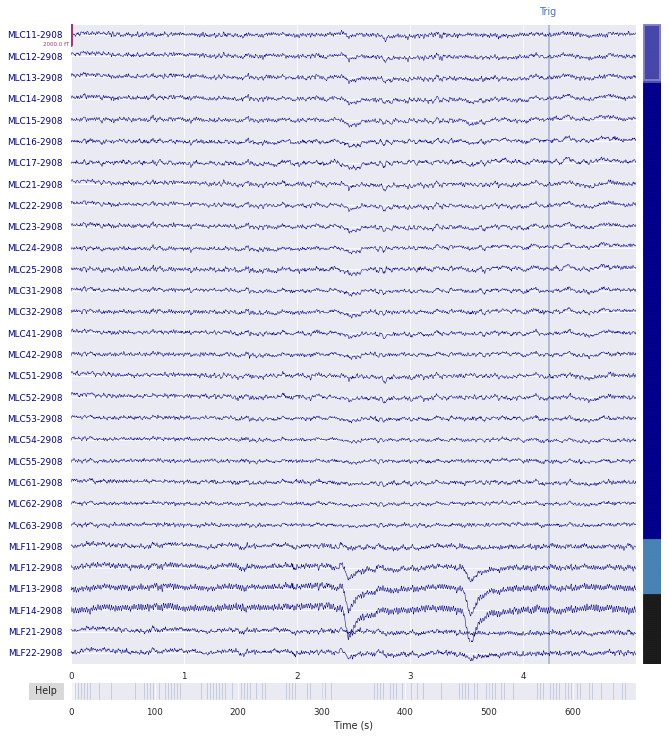

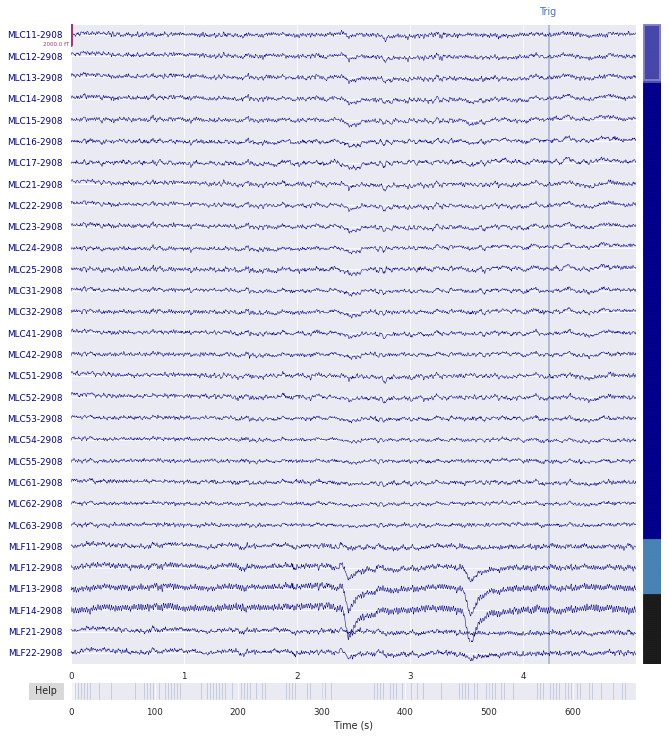

In [5]:
raw.plot(duration=5, n_channels=30)

OPTIONAL:

1. Run the code up to here as a Python script (**not** notebook) to spawn *interactive* data visualization and annotation.
2. Use the horizontal and vertical scroll bars to browse the data.
3. Do you see bad channels? Click on them! They should become gray.
4. Close the window when done.

TIP: Don't reinvent the wheel. Often there is a library for your use case out there. Or many time a method to do what you want inside the library you're already using.
Doing a brief search before you start programming can save you a lot of time and headaches!

### Downsampling to save memory

To save memory and speed computations, we can downsample the data heavily.
It is not recommended to do it here since it can break the metadata ("jitter triggers") associated with the signal.
Still, we will take the risk to speed things up for the lecture.

Resampling applies a low-pass FIR filter and then selects only a few points from the data.

https://mne.tools/stable/overview/faq.html#resampling-and-decimating

In [6]:
size_before = sys.getsizeof(raw.get_data())
raw.resample(120., npad='auto')
size_after = sys.getsizeof(raw.get_data())

Trigger channel has a non-zero initial value of 255 (consider using initial_event=True to detect this event)
172 events found
Event IDs: [255]
172 events found
Event IDs: [1 2 3]
Trigger channel has a non-zero initial value of 255 (consider using initial_event=True to detect this event)
172 events found
Event IDs: [255]
172 events found
Event IDs: [1 2 3]


In [34]:
print(f"Before:\t{size_before} bytes")
print(f"After:\t{size_after} bytes")
diff = size_after - size_before
sep()
print(f"Diff:\t{diff} bytes")
perc = -(size_before // size_after) * 100
print(f"%:\t{perc}%")

Before:	882569400 bytes
After:	220641080 bytes
------------------------------
Diff:	-661928320 bytes
%:	-400%


### Selecting the channels

We will pick MEG channels since it's more documented for this dataset example.
Bad channels are channels with very high noise or near-zero activity (in EEG, imagine an electrode that detached from the scalp).

In [36]:
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
print(picks)

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 24

### Filtering

Unfortunately neurophysiological data is very noisy.
Filtering is applied extensively

https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html

#### Understanding filters

In [19]:
import numpy as np
from numpy.fft import fft, fftfreq
from scipy import signal
import matplotlib.pyplot as plt

from mne.time_frequency.tfr import morlet
from mne.viz import plot_filter, plot_ideal_filter

import mne

sfreq = 1000.
f_p = 40.
flim = (1., sfreq / 2.)  # limits for plotting


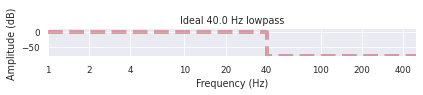

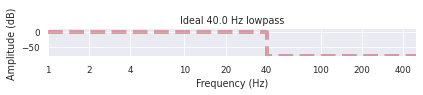

In [20]:
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

third_height = np.array(plt.rcParams['figure.figsize']) * [1, 1. / 3.]
ax = plt.subplots(1, figsize=third_height)[1]
plot_ideal_filter(freq, gain, ax, title='Ideal %s Hz lowpass' % f_p, flim=flim)

#### Applying filters

1. Plot the data before filtering.
2. Apply a filter for 1 and 30 Hz.
3. Repeat the same plot.

Do you observe any difference?

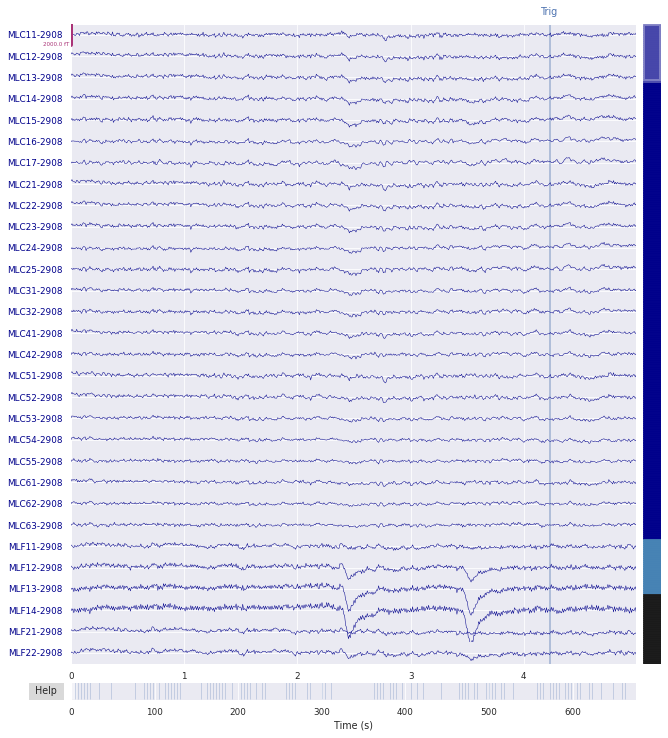

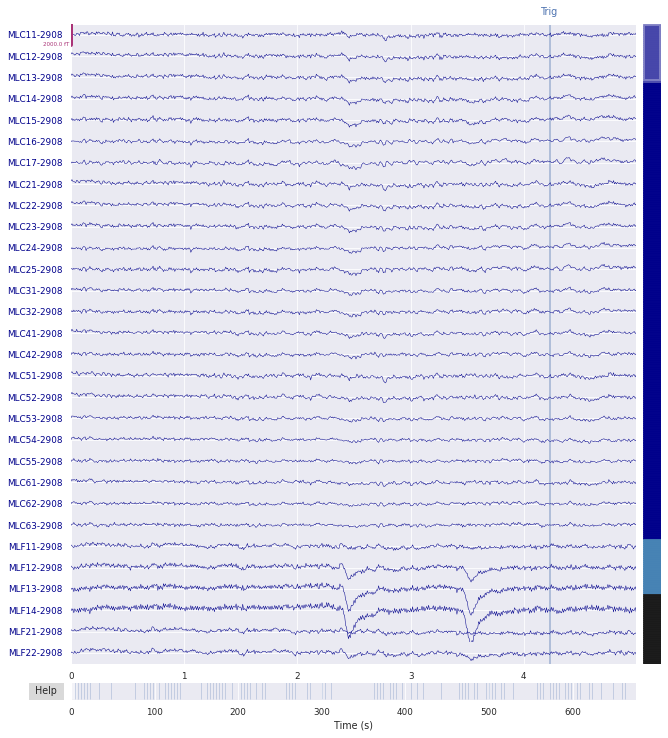

In [39]:
raw.plot(duration=5, n_channels=30)

In [40]:
raw.filter(1, 30, method='fir', fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 397 samples (3.308 sec)



<RawCTF | SPM_CTF_MEG_example_faces1_3D.meg4, 340 x 81118 (676.0 s), ~211.0 MB, data loaded>

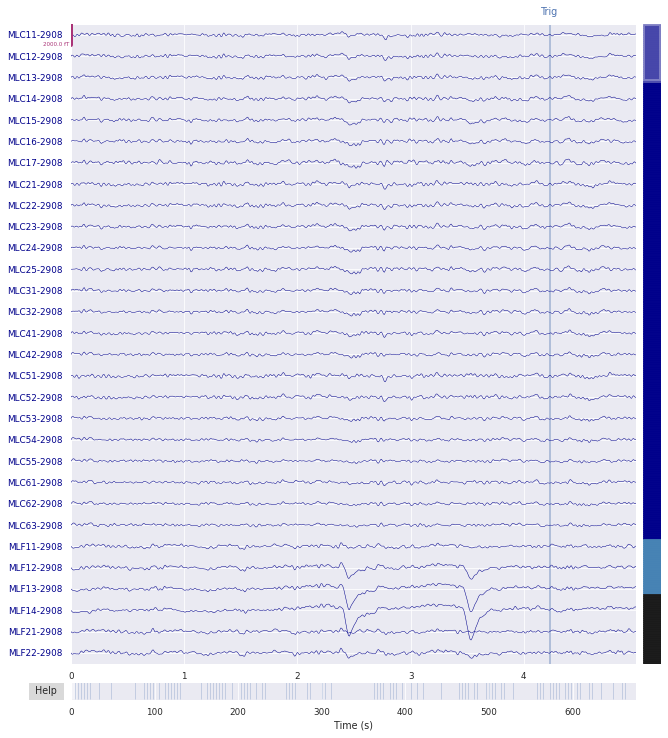

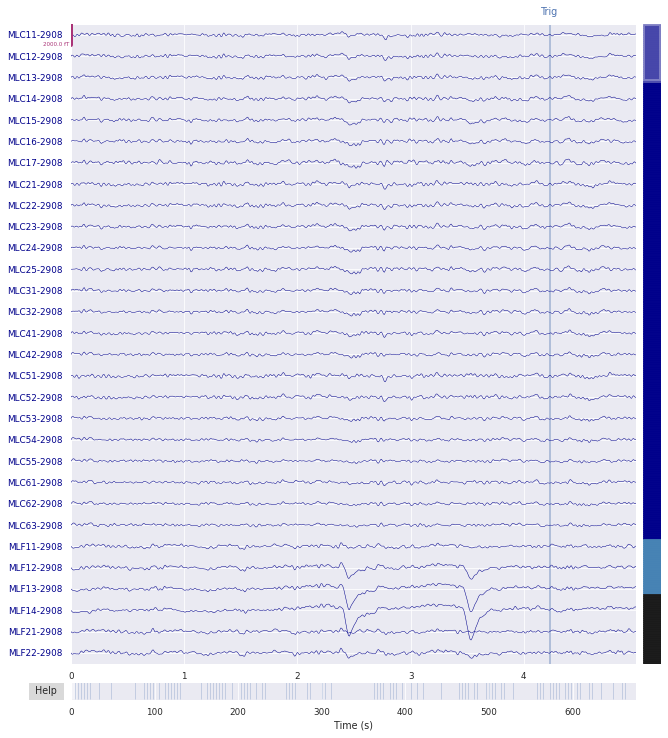

In [41]:
raw.plot(duration=5, n_channels=30)

## Getting the Events

During the experiment, the brain signals are recorded continuously.
At the same time, some external stimuli are occurring.
We need to encode the nature of these external events and time-lock them with the recorded signal.
These events will constitute the associated metadata to the signal e.g. whether at time = 200 the participant saw a normal or scrambled face.

Let's see how events occurred in time!

172 events found
Event IDs: [1 2 3]


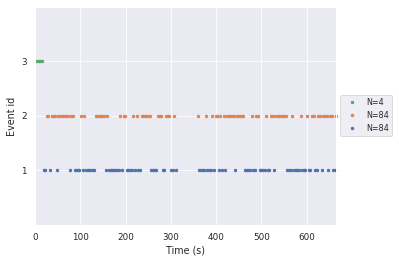

In [42]:
events = mne.find_events(raw, stim_channel='UPPT001')

# plot the events to get an idea of the paradigm
mne.viz.plot_events(events, raw.info['sfreq'])

event_ids = {"faces": 1, "scrambled": 2}

## Epoching

If you remember, we have observed a duality during the lecture:
    
- The data we observe is continuous
- We want to work with selected evoked components of the signal

In other words, we expect to find some sort of pattern that repeats at a certain time with respect to stimuli presentation e.g. P3 in the lectures, N170 here.

The answer to this problem is that we'll combine the information contained in Raw data with Events to find this evoke components.

Let's see the data as it is now again:

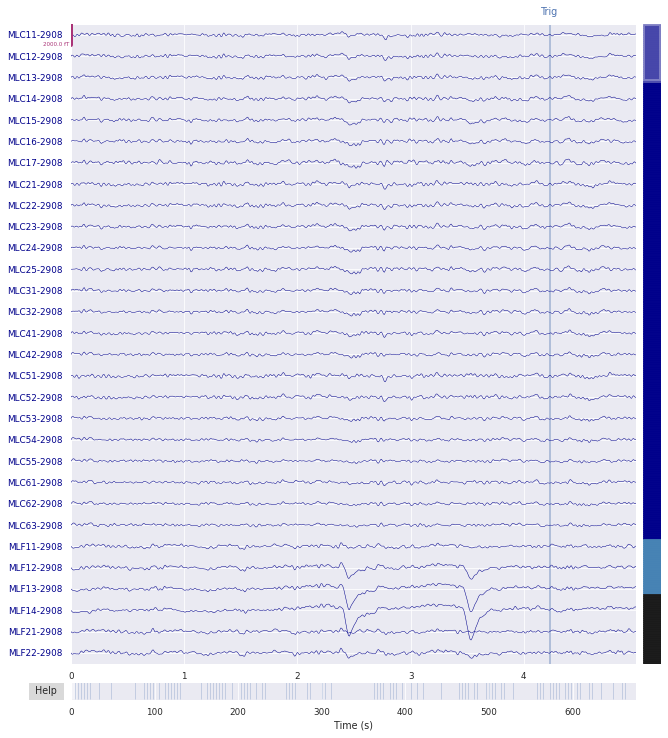

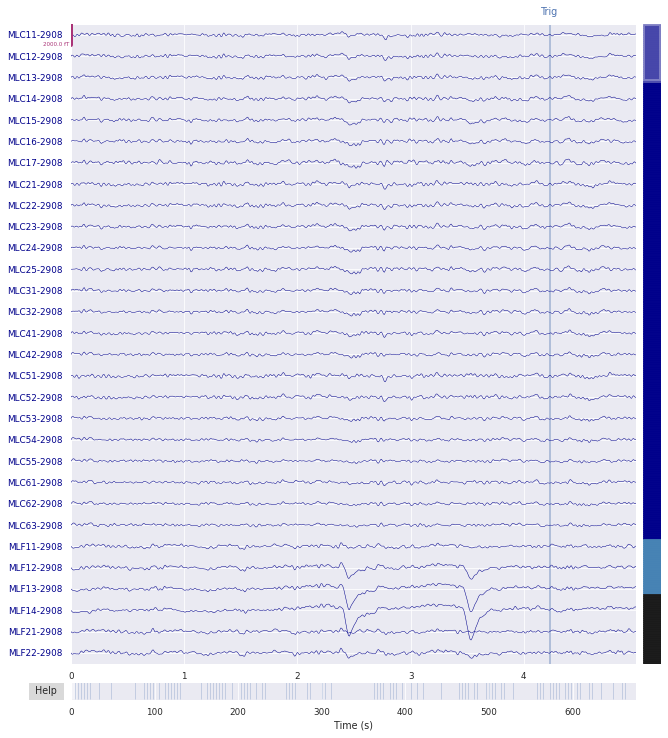

In [43]:
raw.plot(duration=5, n_channels=30)

Select the epochs considering Raw, Events, and a time window.
Use only the channels we selected.

In [45]:
tmin, tmax = -0.2, 0.6
baseline = None  # no baseline as high-pass is applied
reject = dict(mag=5e-12)

epochs = mne.Epochs(raw, events, event_ids, tmin, tmax, picks=picks,
                    baseline=baseline, preload=True, reject=reject)

Not setting metadata
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Loading data for 168 events and 97 original time points ...
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
1 bad epochs dropped


The Epochs object should be more human-friendly.
We can see the two classes of epochs as defined by events:
"faces" and "scrambled"

In [49]:
epochs

Number of events,167
Events,faces: 84scrambled: 83
Time range,-0.200 – 0.600 sec
Baseline,off


Let's visualize the time series but now structured as epochs.
https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html#plotting-epochs-as-time-series

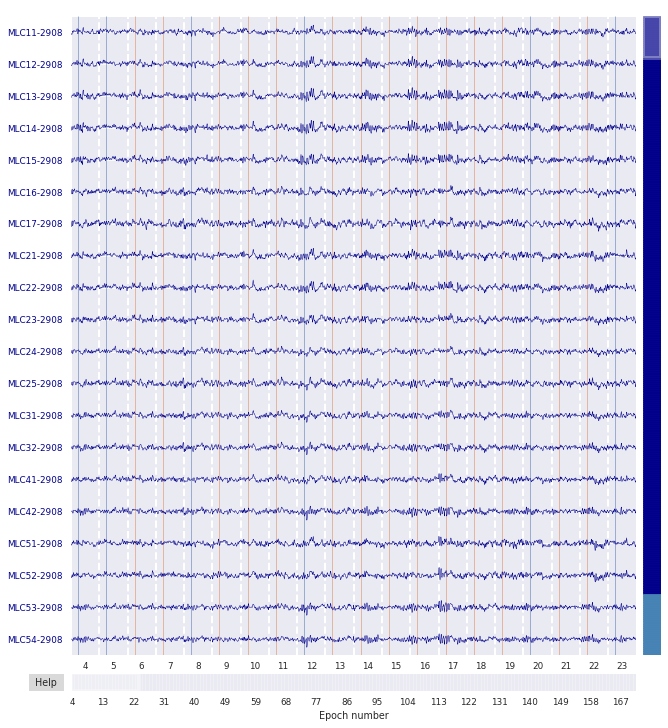

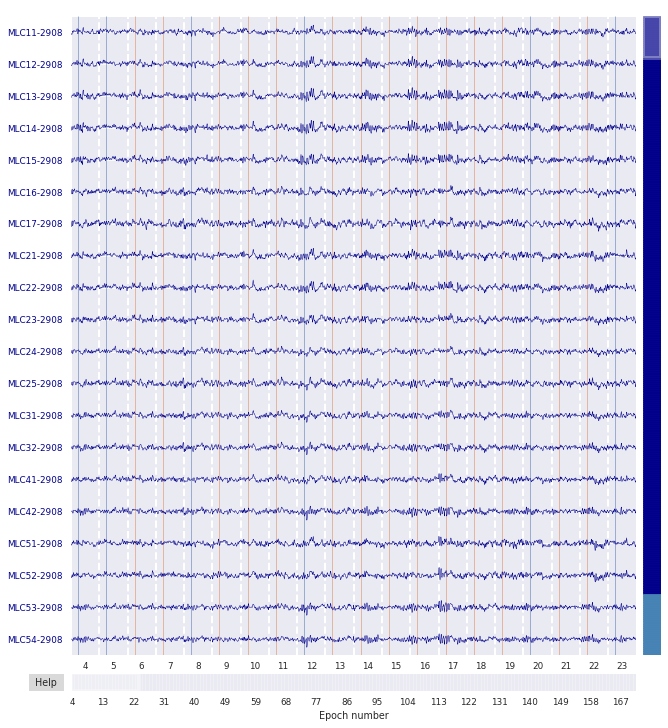

In [53]:
epochs.plot(events=events, event_id=event_ids)

In [ ]:
# Fit ICA, find and remove major artifacts
ica = ICA(n_components=0.95, max_iter='auto', random_state=0)
ica.fit(raw, decim=1, reject=reject)

# compute correlation scores, get bad indices sorted by score
eog_epochs = create_eog_epochs(raw, ch_name='MRT31-2908', reject=reject)
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='MRT31-2908')
ica.plot_scores(eog_scores, eog_inds)  # see scores the selection is based on
ica.plot_components(eog_inds)  # view topographic sensitivity of components
ica.exclude += eog_inds[:1]  # we saw the 2nd ECG component looked too dipolar
ica.plot_overlay(eog_epochs.average())  # inspect artifact removal
ica.apply(epochs)  # clean data, default in place

evoked = [epochs[k].average() for k in event_ids]

contrast = combine_evoked(evoked, weights=[-1, 1])  # Faces - scrambled

evoked.append(contrast)

for e in evoked:
    e.plot(ylim=dict(mag=[-400, 400]))

plt.show()

# estimate noise covarariance
noise_cov = mne.compute_covariance(epochs, tmax=0, method='shrunk',
                                   rank=None)

In [54]:
epochs

Number of events,167
Events,faces: 84scrambled: 83
Time range,-0.200 – 0.600 sec
Baseline,off


## Classifying

Can we guess if the user is seeing a face?

In [59]:
faces = epochs["faces"].get_data()
scrambled = epochs["scrambled"].get_data()

In [58]:
faces

array([[[ 6.89134911e-13,  3.01859535e-13, -2.00021816e-13, ...,
         -8.05934293e-13, -1.42905053e-12, -1.64832140e-12],
        [ 1.58590706e-12,  1.79447566e-12,  2.02684204e-12, ...,
          1.03176693e-12,  1.45421081e-13, -1.13502550e-13],
        [ 4.57516759e-12,  4.32457244e-12,  3.67110655e-12, ...,
          1.13261305e-12,  1.90139202e-13,  2.46709203e-13],
        ...,
        [-1.77537120e-13, -6.28871764e-14,  7.55345569e-14, ...,
         -1.04413316e-13, -3.70225650e-14,  1.21323705e-14],
        [-2.07890126e-13, -9.19415031e-14,  3.89184929e-14, ...,
         -7.65195566e-14, -2.06603627e-14,  5.92092505e-14],
        [ 9.45341284e-15,  4.74840900e-14,  7.89419309e-14, ...,
          6.46232954e-14,  1.12164220e-13,  1.51827587e-13]],

       [[ 5.34621655e-13,  4.66780363e-13,  6.27433621e-13, ...,
         -3.24112121e-13,  1.07158393e-13, -1.68137706e-13],
        [-3.81808858e-13, -6.59149583e-13, -1.03047050e-12, ...,
          1.08425558e-13,  2.54385914e

In [66]:
def _build_event_cat_queries(event_cat):
    """Builds event cat queries then used for features and labels."""

    event_cat_opposites = utils.facecat_categories_opposites()
    event_cat_inverse = event_cat_opposites[event_cat]

    # Training data contains neither the event cat nor its opposite
    selector_train = f"event_cat != '{event_cat}' & event_cat != '{event_cat_inverse}'"
    # Test data contains only the tested event_cat
    selector_test = f"event_cat == '{event_cat}'"

    return selector_train, selector_test


def _get_features(subject, selector_train, selector_test):
    """Selects epoch data for training and testing."""

    features_train = subject.epochs[selector_train]
    features_test = subject.epochs[selector_test]

    return features_train, features_test


def _add_info_labels(labels, data_type):
    """Add the split of labels."""

    labels = pd.concat([labels], keys=[data_type], names=["data_type"])
    labels.name = ("labels", "real")  # Should be True as in sklearn

    return labels


def _get_labels(subject, selector_train, selector_test):
    """Get the labels aplying the same query as for data to epoch metadata"""

    labels_train = subject.epochs[selector_train].metadata["rel"]
    labels_test = subject.epochs[selector_test].metadata["rel"]
    labels = pd.concat(
        [
            _add_info_labels(labels, data_type)
            for data_type, labels in {
                "train": labels_train,
                "test": labels_test,
            }.items()
        ]
    )

    return labels


def _vectorize_epoch_data(epoch_data, frames):
    """Transform epoch data into tensor of shape: event x time_frame*channels."""

    time_axis = 2  # axes: event x channel x time

    data = epoch_data.get_data()

    # Get how many points to preserve to form equal split time frames
    mod_time = find_dividend_for_remainder(
        dividend=data.shape[time_axis], divisor=frames
    )

    # Split data into frames of the same size, discarding points that would prevent that
    split = np.split(data[:, :, :mod_time], frames, axis=time_axis)

    # Average time points within each frame and concat all now averaged frames
    mean = np.hstack([np.mean(split_part, axis=2) for split_part in split])

    return mean


def _build_for_all_event_cats(subject, t_min, t_max, frames):
    """Get transformed features and ables for all event cats and one subject"""

    # subject.epochs.crop(t_min, t_max)

    classifier_data = []
    for event_cat in subject.epochs.event_id.keys():
        data_types = ["train", "test"]

        # Get string queries for all classifier data
        selector_train, selector_test = _build_event_cat_queries(event_cat)

        # Get labels, they contain index
        labels = _get_labels(subject, selector_train, selector_test)

        # Get features
        features = [features_train, features_test] = _get_features(
            subject, selector_train, selector_test
        )
        features = {"train": features_train, "test": features_test}

        # Apply splitting and averaging to both train and test features
        for data_type, features_type in features.items():
            features[data_type] = _vectorize_epoch_data(features_type, frames)
        features = np.vstack([features[data_type] for data_type in data_types])

        features = pd.DataFrame(
            features,
            index=labels.index,
            columns=[
                np.tile("features", features.shape[1]),
                [f"channel_t_frame_{idx}" for idx in range(features.shape[1])],
            ],
        )

        classifier_data_frame = features.join(labels)
        classifier_data_frame = pd.concat(
            [classifier_data_frame], keys=[event_cat], names=["event_cat"]
        )
        classifier_data.append(classifier_data_frame)

    subject.classifier_data = pd.concat(classifier_data)


# def process_all_subjects(subjects, *, t_min=0.050, t_max=0.800, frames=7):
def process_all_subjects(subjects, *, t_min=0.050, t_max=0.800, frames=7):
    """Main to apply to all subjects.

    Parameters
    ----------
    subjects : tuple of object
        Instances of Subject.
    t_min : float, default = 0.050
        Time to start the window.
    t_max : float, default = 0.800
        Time to stop the window.
    frames : int, default = 7
        Total number of frames.

    Returns
    -------
    subjects: tuple of Subject.
        Instances of Subject.
    """

    print("Processing data for classifier...")

    # for subject in tqdm(subjects):
    #     _build_for_all_event_cats(subject, t_min, t_max, frames)
    _build_for_all_event_cats(subject)

    print("Done!")

    return subjects


# if __name__ == "__main__":
#     subs = sub.instantiate_subject(("P01", "P02"))
#     subs = process_all_subjects(subs, t_min=0.050, t_max=0.800, frames=7)
def find_dividend_for_remainder(dividend, divisor, target_remainder=0):
    """Operation"""
    term = 0
    remainder = 1 
    while remainder != target_remainder:
        remainder = (dividend - term) % divisor
        term += 1

    return dividend - term + 1 


In [61]:
faces.shape


(84, 303, 97)

In [62]:
epochs

Number of events,167
Events,faces: 84scrambled: 83
Time range,-0.200 – 0.600 sec
Baseline,off


In [71]:
faces = _vectorize_epoch_data(epochs["faces"], 7)
scrambled = _vectorize_epoch_data(epochs["scrambled"], 7)

In [69]:
faces.shape

(84, 2121)

In [70]:
faces


array([[ 8.57533306e-14,  1.83888571e-12,  4.93564229e-12, ...,
        -1.26098222e-13, -1.04186820e-13,  2.16254401e-14],
       [ 4.06778289e-13, -7.86977748e-13,  3.52588139e-13, ...,
        -8.72030405e-14, -3.14645939e-14,  5.68782686e-14],
       [-1.18572794e-13, -1.63850419e-12, -2.55086335e-12, ...,
        -9.36121433e-14, -1.10016264e-13,  6.61822595e-14],
       ...,
       [-6.91979119e-13, -6.01461125e-13, -1.74736117e-12, ...,
        -1.80695139e-14, -3.75954757e-14,  1.51188340e-13],
       [-2.36162639e-13,  8.48875851e-13,  2.09959747e-12, ...,
        -9.14442995e-14, -8.91889388e-14,  2.60877602e-14],
       [ 3.57064096e-13, -8.13655006e-13, -5.96705177e-13, ...,
        -1.81939035e-14,  6.70990909e-15,  3.01494201e-14]])

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split




First we will put the data in a shape adequate for the classifier.
We will stack all data together:

In [97]:
X = np.vstack((faces, scrambled))

X.shape

(167, 2121)

Then, we make the labels that accompany all data instances.
If the user saw a normal face, give a "1", and if the user saw a scrambled face, give a "0".

In [107]:
y_rel = np.ones(len(faces), dtype=int)
y_irrel = np.zeros(len(scrambled), dtype=int)

print("Labels:")
print(y_rel)
print(y_irrel)

print("\nShapes:")
print(y_rel.shape)
print(y_irrel.shape)

Labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]

Shapes:
(84,)
(83,)


In [108]:
y = np.hstack((y_rel, y_irrel))

print(y)
print(y.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(167,)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0)

Let's take a simple enough model that has shown good performance for similar tasks.
Notice that our data is MEG and the article uses EEG and fMRI!
We're taking shortcuts!
https://www.sciencedirect.com/science/article/pii/S1053811915008460?via%3Dihub

In [99]:
# LDA settings.
solver = "lsqr"
shrinkage = "auto"

lda = LinearDiscriminantAnalysis(solver, shrinkage)

Then we "fit" or "train" the classifier to be able to predict whether a user saw a face or not based solely on the brain signals.

In [101]:
lda = lda.fit(X_train, y_train)

Our classifier is fitted now, and we can use it for prediction.
Let's predict the labels associated with the brain signals we separated for testing.

In [110]:
y_pred = lda.predict(X_test)
print(y_pred)

[0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1]


How do we know if this is a good result or not?
We compare it to the true labels, since those are known.
But how exactly?
We will use a strong metric to evaluate a classifier, the area under the ROC curve.
It takes into account all types of errors ("1" where should have been "0" and vice versa) and output a single number.

What do should you know about this metric?
Only that the closer to 1, the better our results are.

WARNING:
Same as with choosing a classifier, metrics must be chosen with a rationale and must be well understood.
Here we are skipping details since it'd be a lecture or course on its own.

In [1]:
from sklearn.metrics import accuracy_score

print(f"True labels:\t{y_true}")
print(f"Predicte labels:\t{y_pred}")
accuracy_score(y_test, y_pred)

NameError: name 'y_true' is not defined

# Conclusions

A bunch of labels may not be the most flamboyant results ever, BUT think of the implications:

Now, ONLY with any given brain signals in similar experimental conditions, you can predict whether the user is seen a face or not.

No clicks, button presses, no voice commands, no eye movements:
**only passive observation**.

Remember this is just a toy example with readily available datasets and we have taken many shortcuts, but still let's ask ourselves the question: how would we use this in interactive settings?

Maybe we could have some kind of "Brain CAPTCHA" to crowsource whether an unkown image is a face or not?
https://dl.acm.org/doi/10.1145/3313831.3376288


## Appendix: modifying data in place

In [2]:
____________________ = lambda: print("-" * 20)

____________________()
arr = np.arange(5)[::-1]
print(f"Making original array:\t{arr}")
____________________()
np.sort(arr)
print("Sorted the array NOT in place!")
print(f"Original array:\t{arr}")
arr_sorted = np.sort(arr)
print(f"Assigned sorted to another array")
print(f"New array:\t{arr_sorted}")

____________________()
arr = np.arange(5)[::-1]
print(f"Making original array:\t{arr}")
____________________()
arr.sort()
print("Sorted the array IN PLACE!")
print(f"Original array:\t{arr}")
arr_sorted = arr.sort()
print(f"Assigned sorted to another array")
print(f"New array:\t{arr_sorted}")
____________________()

--------------------
Making original array:	[4 3 2 1 0]
--------------------
Sorted the array NOT in place!
Original array:	[4 3 2 1 0]
Assigned sorted to another array
New array:	[0 1 2 3 4]
--------------------
Making original array:	[4 3 2 1 0]
--------------------
Sorted the array IN PLACE!
Original array:	[0 1 2 3 4]
Assigned sorted to another array
New array:	None
--------------------
